# Exercise: Learning to recognise touch sounds
This exercise will look at recognising the audio registered by a piezo contact microphone on a mobile device when different parts of it are touched by a user. This is data from the **Stane** project ([Paper](http://www.dcs.gla.ac.uk/~rod/publications/MurWilHugQua08.pdf) and [video](http://www.dcs.gla.ac.uk/~rod/Videos/i_chi2.mov)), which used 3D printed surfaces to make super-cheap touch controllers.

<img src="imgs/stane_1.png" width="400px">
<img src="imgs/stane_2.png" width="400px">

The machine learning problem is simple: given a set of recordings of a user rubbing discrete touch zones on this 3D printed case, train a classifier which can distinguish which zone is being touched. This is in essence similar to speech recognition, but with a much simpler acoustic problem and no need to deal with language modeling.

We will use multi-class classification to distinguish the touch zones from the audio alone. We can assume a small number of discrete touch areas, and that there is no model governing how they might be touched (i.e. touches happen at random).



## A data processing pipeline
We need to develop a *pipeline* to process the data. There are several stages common to most supervised learning tasks:

1. Loading the original data (from files, databases etc.)
1. Pre-processing (removing outliers, resampling or interpolating, raw normalisation)
1. Feature extraction (transforming data into fixed length feature vectors)
1. Feature processing (offset removal and normalisation)
1. Data splitting (dividing into testing and training sections)
1. Classification (training the classifier)
1. Evaluation (testing the classifier performance)



In [30]:
# standard imports
import numpy as np
import scipy.io.wavfile as wavfile
import scipy.signal as sig
import matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.cluster, sklearn.tree, sklearn.neighbors, sklearn.ensemble, sklearn.multiclass, sklearn.feature_selection
import ipy_table
import sklearn.svm, sklearn.cross_validation, sklearn.grid_search, sklearn.metrics, sklearn.datasets, sklearn.decomposition, sklearn.manifold
import pandas as pd
import seaborn
import scipy.ndimage
# force plots to appear inline on this page
%matplotlib inline

## Step 1: Loading the data
The first thing we need to do is to load the data. The data is in `datasets/stane/` and consists of five wave files from scratching five different surfaces, each 60 seconds in length, 4Khz, 16 bit PCM. 



In [5]:
%cd datasets\stane
%ls

C:\work\summerschool2015\datasets\stane
 Volume in drive C is OS
 Volume Serial Number is F2AC-1EA1

 Directory of C:\work\summerschool2015\datasets\stane

11/06/2015  10:39    <DIR>          .
11/06/2015  10:39    <DIR>          ..
15/09/2007  00:11           491,530 stane_1.wav
15/09/2007  00:12           491,518 stane_2.wav
15/09/2007  00:15           491,472 stane_3.wav
15/09/2007  00:14           491,540 stane_4.wav
15/09/2007  00:17           491,558 stane_5.wav
               5 File(s)      2,457,618 bytes
               2 Dir(s)  309,067,259,904 bytes free


Since these are just plain wave files, we can listen to the data using aplay:

In [67]:
# play the first five seconds of these two files
!aplay stane_2.wav -d 5
!aplay stane_4.wav -d 5


'aplay' is not recognized as an internal or external command,
operable program or batch file.
'aplay' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# load each of the files into sound_files
sound_files = []
for texture in "12345":
    # load the wavefile
    fname = "stane_%s.wav" % texture
    sr, data = wavfile.read(fname)
    print "Loaded %s, %s samples at %dHz (%f seconds)" % (fname, len(data), sr, len(data)/float(sr))
    sound_files.append(data)
    
    

Loaded stane_1.wav, 245743 samples at 4096Hz (59.995850 seconds)
Loaded stane_2.wav, 245737 samples at 4096Hz (59.994385 seconds)
Loaded stane_3.wav, 245714 samples at 4096Hz (59.988770 seconds)
Loaded stane_4.wav, 245748 samples at 4096Hz (59.997070 seconds)
Loaded stane_5.wav, 245757 samples at 4096Hz (59.999268 seconds)


This has loaded each of the wave files into `sound_files[]`, one for each of our 5 classes. We must process this into fixed length feature vectors which we can feed to a classifier. This is the major "engineering" of the machine learning process -- good feature selection is essential to getting good performance.

It's important that we can change the parameters of the feature extraction and learning and be able to rerun the entire process in one go. We define a dictionary called `params` which will hold every adjustable parameter and a function called `run_pipeline()` which will run our entire pipeline. For now, it does nothing.

In [7]:
params = {'sample_rate':4096,
         }

def run_pipeline(sound_files, params):            
    # this is the outline of our pipeline
    pre_processed = pre_process(sound_files, params)
    features, targets = feature_extract(pre_processed, params)
    train, validate, test = split_features(features, targets, params)    
    classifier = train_classifier(features, targets, params)
    evaluate(classifier, features, targets, params)
    
    

## Step 2: Pre-processing
This data is pretty clean already. We can plot a section of the data to have a look at it:


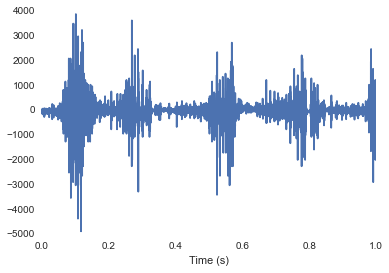

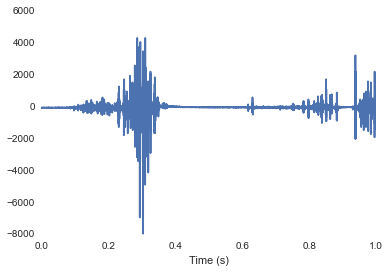

In [8]:
one_second = params["sample_rate"]

# plot two of the files
plot_section_0 = sound_files[0][:one_second] 
plot_section_1 = sound_files[1][:one_second] 

# generate time indices
timebase = np.arange(len(plot_section_0)) / float(params["sample_rate"])
plt.figure()
plt.plot(timebase, plot_section_0)
plt.xlabel("Time (s)")
plt.figure()
plt.plot(timebase, plot_section_1)
plt.xlabel("Time (s)")



We can also view this in the frequency domain using `plt.specgram()`. We have to choose an FFT size and overlap (here I used N=256 samples, overlap=128)

In [ ]:
# the cmap= just selects a prettier heat map
_ = plt.specgram(plot_section_0, NFFT=256, Fs=params["sample_rate"], noverlap=128, cmap="gist_heat")
plt.figure()
_ = plt.specgram(plot_section_1, NFFT=256, Fs=params["sample_rate"], noverlap=128, cmap="gist_heat")

### Preprocessing steps
Two things we should do in the pre-processing step:
1. normalise the data to 0-1 range
2. apply bandpass filtering to select frequencies we are interested in

In [9]:
def bandpass(x, low, high, sample_rate):
    # scipy.signal.filtfilt applies a linear filter to data (*without* phase distortion)
    # scipy.signal.butter will design a linear Butterworth filter     
    nyquist = sample_rate / 2    
    b,a = sig.butter(4, [low/float(nyquist), high/float(nyquist)], btype="band")    
    return sig.filtfilt(b,a,x)
    

def pre_process(sound_files, params):    
    processed = []
    for sound_file in sound_files:
        normalised = sound_file / 32768.0
        p = bandpass(normalised, params["low_cutoff"], params["high_cutoff"], params["sample_rate"])
        processed.append(p)
    return processed
        
        

###  Testing pre-processing
We can test this and check it working by plotting the time series and spectrogram before and after. We can create a quick function to plot this:

In [10]:
def plot_second(x, params):
    one_second = params["sample_rate"]
    plot_section = x[:one_second] 
    # generate time indices
    timebase = np.arange(len(plot_section)) / float(params["sample_rate"])
    plt.figure()
    plt.plot(timebase, plot_section)
    plt.ylabel("Amplitude")
    plt.xlabel("Time (s)")
    plt.figure()
    _ = plt.specgram(plot_section, NFFT=256, Fs=params["sample_rate"], noverlap=128, cmap='gist_heat')
    plt.ylabel("Freq (Hz)")
    plt.xlabel("Time (s)")
    
    
    

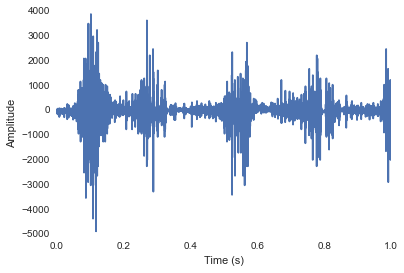

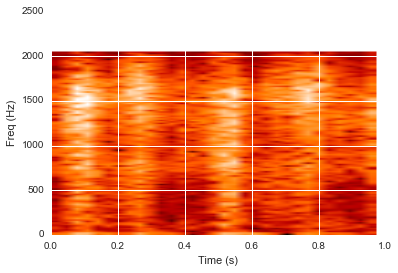

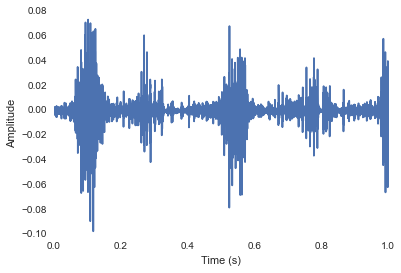

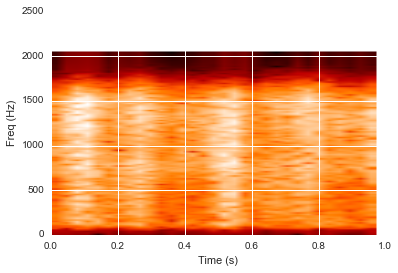

In [11]:
# test the filtering; these are example values only
params["low_cutoff"]=100
params["high_cutoff"]=1500
processed = pre_process(sound_files, params)

# plot the results
plot_second(sound_files[0], params)
plot_second(processed[0], params)




## Feature extraction

The next step is to make fixed length feature vectors. This requires some assumptions: we have a continuous signal, so how do we split it up? What processing should we apply to transform the data?  

The obvious thing to do with a time series is to split it into *windows* of a fixed length. These windows can be overlapping (i.e. the next window can include part of the previous one). The function sliding_window() below splits up a 1D time series into such overlapping windows. 

In [12]:
def sliding_window(x, length, overlap):
    """Split x into windows of the given length, with the specified overlap"""
    wins = len(x)//(length-overlap)
    windows = []
    offset = 0
    for i in range(wins):
        windows.append(x[offset:offset+length])
        offset += length-overlap
    return windows
    
    

In [16]:
# for example
sliding_window(sound_files[0], 512, 256);

## Exercise 1
Exercise: Produce a feature matrix for the sound files using sliding window, and a corresponding label vector.

Hint: you can use `np.full(n, x)` to generate a vector [x,x,x,x,...] and `np.vstack(l)` to stack a list of vectors into a matrix.

Make the window size and overlap part of `params` (`window_length` and `overlap`) and write a function features, labels = make_features(processed, params)

In [18]:
params['window_overlap'] = -1024
params['window_length'] = 256
features, labels = make_features(processed, params)
print features.shape

(955L, 256L)


## Feature transform
The raw audio data isn't a great feature for classification. We can apply transformations to the feature vectors to improve the features. The Fourier transform is one way of doing that. To avoid artifacts, each section must have a *window function* applied to taper off the signal at the ends and avoid a large discontinuity.

In [29]:
def transform_features(data):
    # window features and compute magnitude spectrum
    # try different window functions (e.g. Hann, Blackman-Harris)
    window = sig.hamming(features.shape[1])
    fft_features = np.abs(np.fft.fft(features * window))
    return fft_features

print transform_features(features).shape


(955L, 256L)


## Exercise 2
Adjust transform_features to "rebin" the features by merging together elements (e.g. transforming a 256 element array to a 32 element array). The scipy.ndimage.zoom function is an efficient way of doing this.

## Exercise 3
Make a 2D plot of the data using a dimensional reduction technique (PCA, tSNE, LLE) from sklearn. Plot the resulting features as a scatter plot, coloured by their label.



## Exercise 4
Build a classifier using sklearn to classify this data. You should make sure you:

* normalise the features (sklearn.preprocessing)
* split into a test and train set
* choose a classifcation model. Use two classes to begin with, then extend to multi-class classification, using sklearn.multiclass.
* adjust the hyperparameters using cross-validation and grid search [you may need to use a subsample of the data]
* evaluate the performance of the classifer. Produce ROC curves and a confusion matrix.
